In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.gridspec as gridspec

In [2]:
def get_most_deleterious_idx(ser):
    all_masks = set(ser.unique())
    most_del = "Missense_lenient"
    if "pLoF" in all_masks:
        most_del = "pLoF"
    elif "Missense_strict" in all_masks:
        most_del = "Missense_strict"
    most_del_idx = ser.loc[ser==most_del].index[0]
    return most_del_idx

def get_meta_df(aou_file, ukb_file, most_del_sig_meta_df):
    aou_df = pd.read_csv(aou_file, index_col=[0, 1])
    ukb_df = pd.read_csv(ukb_file, index_col=[0, 1])
    meta_df = aou_df+ukb_df
    meta_df = meta_df.reset_index()
    meta_df = meta_df.rename(columns={"mask": "gene_mask"})
    meta_df = most_del_sig_meta_df.loc[:, ["gene", "gene_mask"]].merge(meta_df, on=["gene", "gene_mask"])
    return meta_df


In [ ]:
PROJECT_DIR = "/Users/deeprobanerjee/Documents/bmi_project/BMI_monogenic"

# keep most deleterious mask for sig genes
filename = os.path.join(PROJECT_DIR, "data/meta/results/all_ancestry/ivw_fixed/bmi_rint_monogenic_meta.tsv")
sig_meta_res_df = pd.read_csv(filename, sep="\t")
most_del_sig_meta_df = sig_meta_res_df.loc[sig_meta_res_df.groupby("gene")["gene_mask"].apply(get_most_deleterious_idx)].sort_values("beta", ascending=False).reset_index(drop=True)

# read previously calculated odds ratio file and keep most del masks
filename = os.path.join(PROJECT_DIR, "data/enrichment/bmi_cat/monogenic_enrich_bmi_cat.csv")
bmi_cat_df = pd.read_csv(filename)
bmi_cat_df = most_del_sig_meta_df.loc[:, ["gene", "gene_mask"]].merge(bmi_cat_df, on=["gene", "gene_mask"])

# read the meta file with number of individuals per gene stratified by obesity cat
analysis = "bmi_cat"
aou_file = os.path.join(PROJECT_DIR, f"data/enrichment/{analysis}/monogenic_aou_{analysis}.csv.gz")
ukb_file = os.path.join(PROJECT_DIR, f"data/enrichment/{analysis}/monogenic_ukb_{analysis}.csv.gz")
thresh_meta_df = get_meta_df(aou_file, ukb_file, most_del_sig_meta_df)
# change it to long format
thresh_meta_long_df = thresh_meta_df.melt(id_vars=["gene", "gene_mask"],  value_vars=["gene_nu", "gene_ovw", "gene_ob", "gene_sob"], var_name="category", value_name="nsamples")
thresh_meta_long_df["category"] = thresh_meta_long_df.category.map({"gene_nu": "underweight_normal", "gene_ovw": "overweight", "gene_ob": "obese", "gene_sob": "severely_obese"})
# calculate percentage of samples per category for each gene
total_samples_per_gene = thresh_meta_long_df.groupby("gene")["nsamples"].transform("sum")
thresh_meta_long_df["percent"] = thresh_meta_long_df["nsamples"].div(total_samples_per_gene)*100

# create dictionary with percentage for each gene - make sure genes are sorted based on their p values before
genes = most_del_sig_meta_df.gene.unique()
cwc = dict()

bmi_categories = ["underweight_normal", "overweight", "obese", "severely_obese"]

for cat in bmi_categories:
    cwc[cat] = thresh_meta_long_df.loc[thresh_meta_long_df.category==cat, "percent"].values

bmi_cat_df["comorbidity"] = bmi_cat_df.comorbidity.map({
    "nu": "underweight_normal", "ovw": "overweight", "ob": "obese", "sob": "severely_obese"
    })

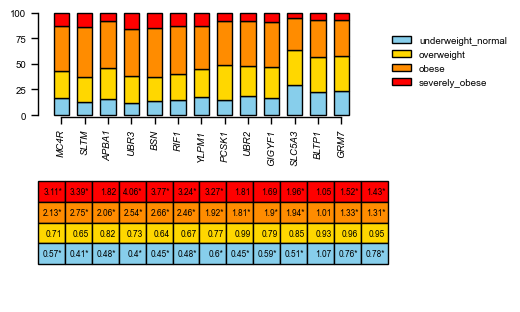

In [4]:
width = 0.65

fig = plt.figure(figsize=(5, 3.5)) #, (ax1, ax2) = plt.subplots(2,1, figsize=(4, 6), height_ratios=(3, 3), sharex=True)

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.5])

# Create the bar plots
ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1])

colors = ["skyblue", "gold", "darkorange", "red"] #sns.color_palette("tab20", 5)
positions1 = [i for i in range(len(genes))]
bottom = np.zeros(len(genes))
for bmi_cat,col in zip(bmi_categories, colors):
    weight_count = cwc[bmi_cat]
    p = ax1.bar(positions1, weight_count, width, label=bmi_cat, bottom=bottom, color=col, edgecolor="k")
    bottom += weight_count

# Add a table at the bottom of the Axes

cell_text = []
cell_colors = []
    
for obese_spec, color in zip(bmi_categories[::-1], colors[::-1]):
    OR = []
    for gene in list(genes):
        orr = bmi_cat_df.loc[(bmi_cat_df.gene==gene)&(bmi_cat_df.comorbidity==obese_spec), "OR"].values[0]
        pval = bmi_cat_df.loc[(bmi_cat_df.gene==gene)&(bmi_cat_df.comorbidity==obese_spec), "p_value"].values[0]
        starp=""
        if pval<0.05/(len(genes)*len(bmi_categories)):
            starp="*"
        OR.append(str(round(orr, 2))+starp)
    cell_text.append(OR)
    cell_colors.append([color for _ in range(len(list(genes)))])

ax_table = fig.add_subplot(gs[1])
ax_table.axis('off')
the_table = ax_table.table(cellText=cell_text,
                           cellColours=cell_colors,
                        #    rowLabels=["overweight", "obese", "severely obese"],
                        #    rowColours=colors[2:],
                        #    colLabels=[f"{i}" for i in range(1, 11)],
                           loc='center', cellLoc="right", rowLoc="center")


# Adjust the table's positioning
# the_table.auto_set_font_size(False)
the_table.set_fontsize(6)
the_table.scale(1, 1.15)  # Adjust the scale to fit the plot

ax1.legend(loc=(1, 0.25), ncol=1, frameon=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_xticks(positions1, genes, fontsize=7, fontstyle="italic", rotation=90)
ax1.set_xlim(-1, len(genes)+1)

ax1.set_ylim(-2, 101)
ax1.spines['bottom'].set_bounds(ax1.get_xticks()[0], ax1.get_xticks()[-1])
ax1.spines['left'].set_bounds(0, 100);

plt.subplots_adjust(left=0.2, bottom=0.05)

# Add connecting lines


In [5]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [6]:
filename = os.path.join(PROJECT_DIR, "data/enrichment/bmi_cat/obesity_cat.pdf")
save_pdf(filename, fig)
